Summer 2023 - Final Project

Pragya Acharya and Dounia Bellouk

Objective: 
To investigate the relationship between fertility rates and economic development across countries over time, using both regression and time series analysis.

In [ ]:
#Optional : install packages
%pip install requests
%pip install warnings
%pip install numpy
%pip install pandas
%pip install matplotlib.pyplot
%pip install seaborn
%pip install statsmodels

In [5]:
# Import Libraries
import requests
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR


Data Collection and cleaning :
1. Use the World Bank API to collect fertility rate data by country for a specified time period (e.g. 1980-2020). [https://api.worldbank.org/v2/countries/all/indicators/SP.DYN.TFRT.IN]
2. Collect data on economic indicators such as GDP per capita, inflation rate, and unemployment rate for the same time period and countries.
3. Clean the collected data to remove any missing or incorrect values

In [6]:
# To ignore all warnings
warnings.filterwarnings("ignore")

# World Bank API URLs for different indicators
indicator_urls = {
    "Fertility Rate": "https://api.worldbank.org/v2/countries/all/indicators/SP.DYN.TFRT.IN",
    "GDP per Capita": "https://api.worldbank.org/v2/countries/all/indicators/NY.GDP.PCAP.CD",
    "Inflation Rate": "https://api.worldbank.org/v2/countries/all/indicators/FP.CPI.TOTL.ZG",
    "Unemployment Rate": "https://api.worldbank.org/v2/countries/all/indicators/SL.UEM.TOTL.ZS",
    "Population": "https://api.worldbank.org/v2/countries/all/indicators/SP.POP.TOTL"
}

# Common parameters for all requests
params = {
    "format": "json",
    "date": "1980:2020",
    "per_page": 1000,
    "source": "2"
}

# Function to fetch and clean data for a given indicator
def fetch_and_clean_data(url, indicator_name):
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()[1]
        cleaned_data = []
        for entry in data:
            country = entry["country"]["value"]
            value = entry["value"]
            year = entry["date"]
            if value is not None:
                cleaned_data.append({"Country": country, "Year": year, "Value": value})
        return cleaned_data
    else:
        print(f"Failed to fetch {indicator_name} data. Status code: {response.status_code}")
        return []

# Fetch and clean data for each indicator
cleaned_data_by_indicator = {}
for indicator_name, indicator_url in indicator_urls.items():
    cleaned_data = fetch_and_clean_data(indicator_url, indicator_name)
    cleaned_data_by_indicator[indicator_name] = cleaned_data

# Printing top 10 cleaned data
for indicator_name, cleaned_data in cleaned_data_by_indicator.items():
    print(f"{indicator_name} Data:")
    for entry in cleaned_data[:5]:
        print(entry)
    print("=" * 40)


Fertility Rate Data:
{'Country': 'Africa Eastern and Southern', 'Year': '2020', 'Value': 4.41690032191029}
{'Country': 'Africa Eastern and Southern', 'Year': '2019', 'Value': 4.48289806728591}
{'Country': 'Africa Eastern and Southern', 'Year': '2018', 'Value': 4.52770519140796}
{'Country': 'Africa Eastern and Southern', 'Year': '2017', 'Value': 4.5704088889247}
{'Country': 'Africa Eastern and Southern', 'Year': '2016', 'Value': 4.61566985634981}
GDP per Capita Data:
{'Country': 'Africa Eastern and Southern', 'Year': '2020', 'Value': 1353.9275274008}
{'Country': 'Africa Eastern and Southern', 'Year': '2019', 'Value': 1499.9544365215}
{'Country': 'Africa Eastern and Southern', 'Year': '2018', 'Value': 1550.11176204468}
{'Country': 'Africa Eastern and Southern', 'Year': '2017', 'Value': 1613.66848779126}
{'Country': 'Africa Eastern and Southern', 'Year': '2016', 'Value': 1436.09440388982}
Inflation Rate Data:
{'Country': 'Africa Eastern and Southern', 'Year': '2020', 'Value': 7.3211064341

In [7]:
# Create a dictionary to store dataframes for each indicator
dataframes_by_indicator = {}

# Loop through cleaned data for each indicator
for indicator_name, cleaned_data in cleaned_data_by_indicator.items():
    # Create a dataframe from the cleaned data
    df = pd.DataFrame(cleaned_data)
    
    # Pivot the dataframe to have countries as columns and time as the index
    df_pivot = df.pivot(index='Year', columns='Country', values='Value')
    
    # Sort the columns by country name for better readability
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)
    
    # Store the resulting dataframe in the dictionary
    dataframes_by_indicator[indicator_name] = df_pivot

# Create dataframes for each indicator
fertility_rate_df = dataframes_by_indicator["Fertility Rate"]
gdp_per_capita_df = dataframes_by_indicator["GDP per Capita"]
inflation_rate_df = dataframes_by_indicator["Inflation Rate"]
unemployment_rate_df = dataframes_by_indicator["Unemployment Rate"]
population_df = dataframes_by_indicator["Population"]

# Print the dataframes
print (fertility_rate_df)
print (gdp_per_capita_df)
print (inflation_rate_df)
print (unemployment_rate_df)
print (population_df)

Country  Africa Eastern and Southern  Africa Western and Central  Arab World  \
Year                                                                           
1980                        6.704623                    6.896995    6.353993   
1981                        6.672362                    6.880294    6.266880   
1982                        6.638489                    6.855267    6.185035   
1983                        6.604408                    6.830516    6.096443   
1984                        6.565696                    6.780680    5.986973   
1985                        6.514957                    6.726142    5.872418   
1986                        6.464310                    6.683321    5.737496   
1987                        6.419489                    6.636463    5.600279   
1988                        6.344942                    6.599015    5.450477   
1989                        6.263838                    6.565149    5.289032   
1990                        6.166608    

Data Processing

1. Calculate the mean and standard deviation of fertility rates and economic indicators for each country over the specified time period.
2. Merge the fertility rate and economic indicator data by country.
3. Convert the data to a time series format, with time as the index and each country as a separate column.

In [8]:
# Calculate mean and standard deviation for each indicator by country
indicator_stats_by_country = {}
for indicator_name, cleaned_data in cleaned_data_by_indicator.items():
    country_data = {}
    for entry in cleaned_data:
        country = entry["Country"]
        value = entry["Value"]
        if country not in country_data:
            country_data[country] = []
        country_data[country].append(value)
    
    country_stats = {}
    for country, values in country_data.items():
        mean = np.mean(values)
        std_dev = np.std(values)
        country_stats[country] = {"Mean": mean, "Standard Deviation": std_dev}
    
    indicator_stats_by_country[indicator_name] = country_stats

# Printing mean and standard deviation for each indicator by country
#for indicator_name, country_stats in indicator_stats_by_country.items():
    #print(f"{indicator_name} Statistics by Country:")
    #for country, stats in country_stats.items():
        #print(f"Country: {country}")
        #print(f"Mean: {stats['Mean']:.2f}")
        #print(f"Standard Deviation: {stats['Standard Deviation']:.2f}")
        #print("-" * 20)
    #print("=" * 40)
    
    # Merge data by country
merged_data = {}
for indicator_name, cleaned_data in cleaned_data_by_indicator.items():
    for entry in cleaned_data:
        country = entry["Country"]
        year = entry["Year"]
        value = entry["Value"]
        if country not in merged_data:
            merged_data[country] = {"Country": country}
        merged_data[country][indicator_name] = value

# Printing merged data
for country, data in merged_data.items():
    for indicator_name, value in data.items():
        print(f"{indicator_name}: {value}")
    print("=" * 40)

Country: Africa Eastern and Southern
Fertility Rate: 6.70462343655892
GDP per Capita: 741.305704886249
Inflation Rate: 15.0665115372509
Unemployment Rate: 7.33333582862451
Population: 230967858
Country: Africa Western and Central
Fertility Rate: 6.89699501373668
GDP per Capita: 712.426374259141
Inflation Rate: 8.79921083308779
Unemployment Rate: 4.22459513680231
Population: 157825609
Country: Arab World
Fertility Rate: 6.35399330182899
GDP per Capita: 2741.71041336197
Inflation Rate: 9.62605664613179
Unemployment Rate: 11.6634431372264
Population: 167707208
Country: Caribbean small states
Fertility Rate: 3.56332165348296
GDP per Capita: 2434.17914272633
Inflation Rate: 17.4703042795772
Unemployment Rate: 12.2038289936464
Population: 5544061
Country: Central Europe and the Baltics
Fertility Rate: 2.19590929473033
GDP per Capita: 2305.67634682273
Inflation Rate: 118.527578905984
Unemployment Rate: 9.22374145120565
Population: 106541316
Country: Early-demographic dividend
Fertility Rate: 

Data Visualization

1. Create a line chart of fertility rates over time for each country.

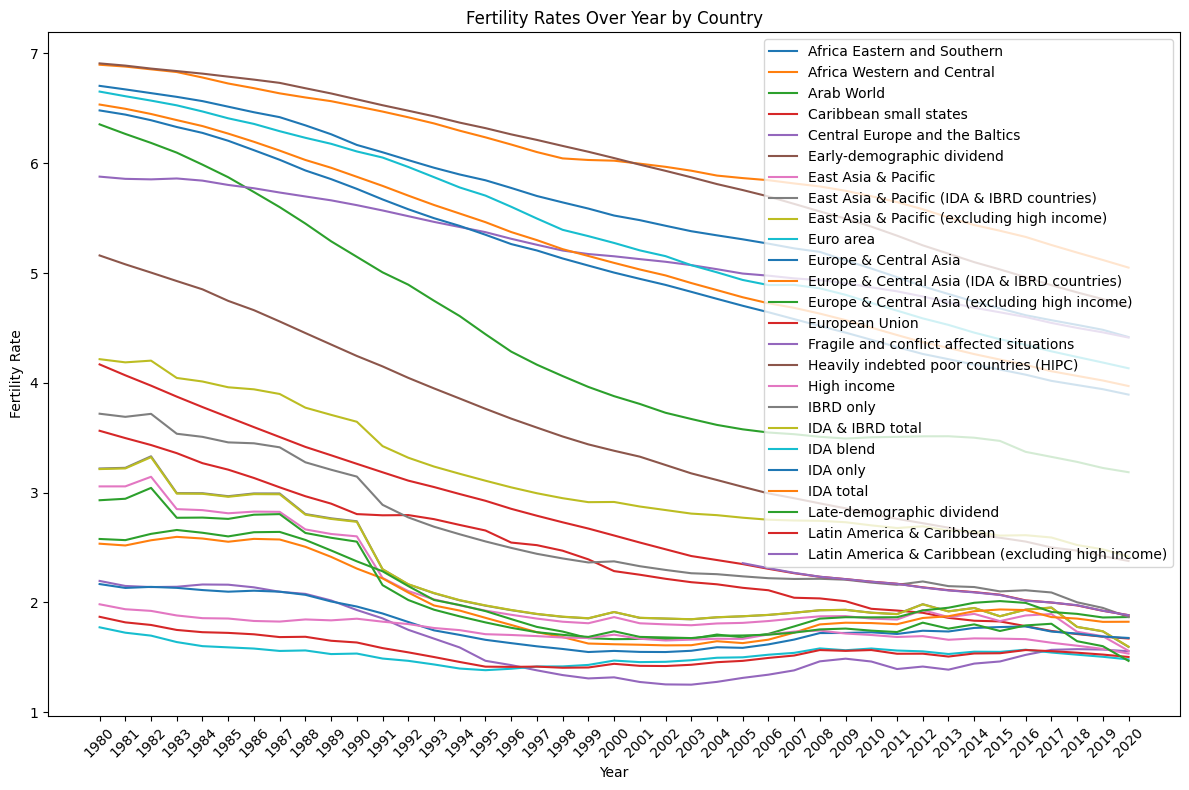

In [9]:
# Plot the line chart
plt.figure(figsize=(12, 8))

# Plot each country's fertility rate over Year
for country in fertility_rate_df.columns:
    plt.plot(fertility_rate_df.index, fertility_rate_df[country], label=country)

# Add labels and title
plt.xlabel("Year")
plt.ylabel("Fertility Rate")
plt.title("Fertility Rates Over Year by Country")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

For all countries or, more generally, all georgraphical areas, the fertility rate tends to decrease over the past decades. We can also notice that the countries that had the highest fertility rate in the early 1980's are those whose rate decreased the most until now. As a result, there is a phenomenon of convergence between some parts of the world, especially for the countries who had an "initial" fertility rate below 4 (first half of the graph). This convergence is less accurate for the countries which had a significant initial fertility rate. In terms of comparison, the two extrems areas are western and central Africa, in opposition to the Euro zone.

2. Create a heatmap of fertility rates over time by region.

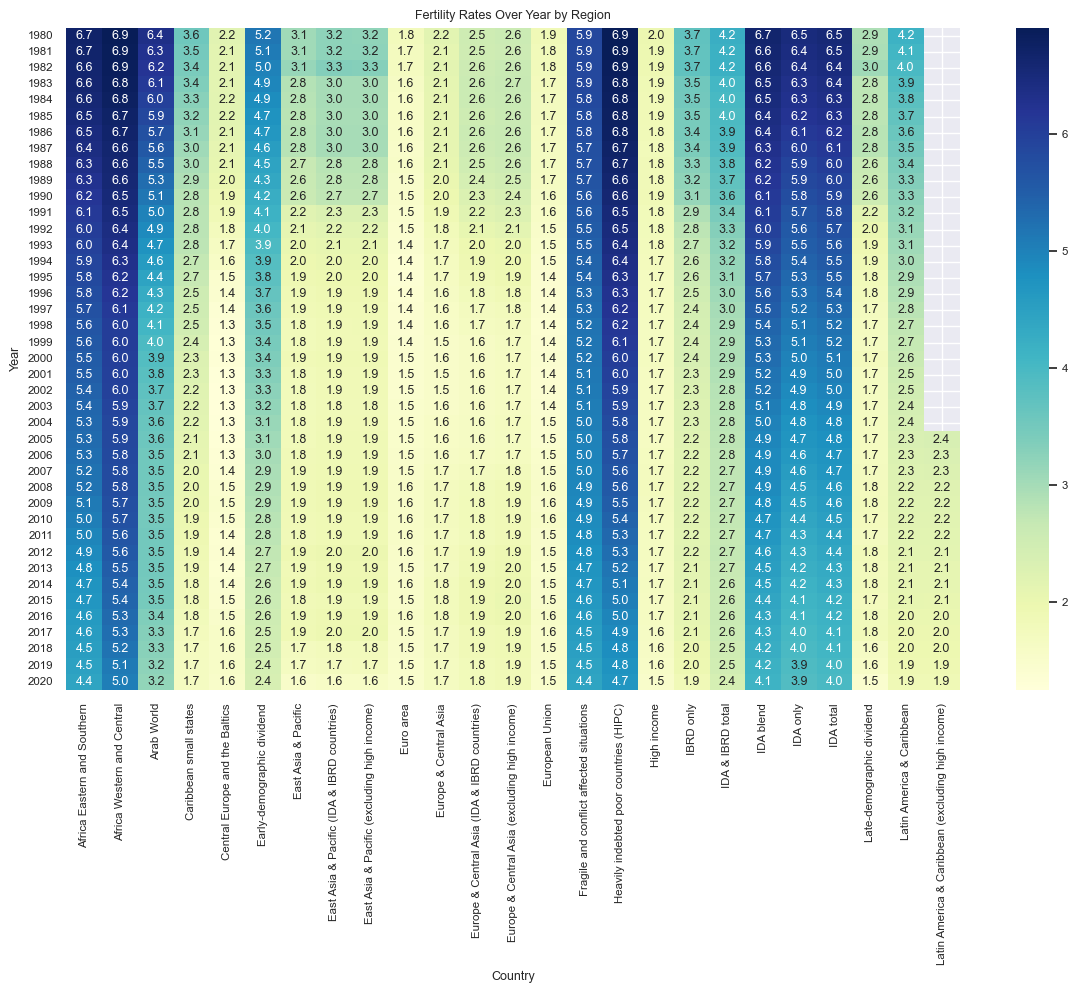

In [10]:
# Create a DataFrame from the fertility rate data
fertility_df2 = pd.DataFrame(cleaned_data_by_indicator["Fertility Rate"])

# Pivot the DataFrame to have Year as rows, Region as columns, and Fertility Rate as values
heatmap_data = fertility_df2.pivot(index="Year", columns="Country", values="Value")

# Set up the heatmap figure
plt.figure(figsize=(12, 10))
sns.set(font_scale=0.75)

# Create the heatmap using Seaborn
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".1f")

# Add labels and title
plt.xlabel("Country")
plt.ylabel("Year")
plt.title("Fertility Rates Over Year by Region")

# Rotate tick labels for better visibility
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

This graph gives another approach as we can quantify the evolution of fertility rate over the years. For example, Euro zone went over a loss of 0.3, whereas Eastern and Southern Africa lose 2.3 units of fertility rate, wich is more than 7 times the decline in Europe. But on the other side, the areas that had a low initial fertility rate went over a higher decrease in terms of percentage. Indeed, East Asia for example lost half of its fertility rate, whereas Eastern and Southern Africa lost the third. But we have to nuance those remarks, as there are some counter examples as the Arabic World, which had a high initial fertility rate and also went over a decrease of half of it.

3. Create a scatter plot of fertility rates vs. GDP per capita for all countries, with the size of the markers indicating the population size

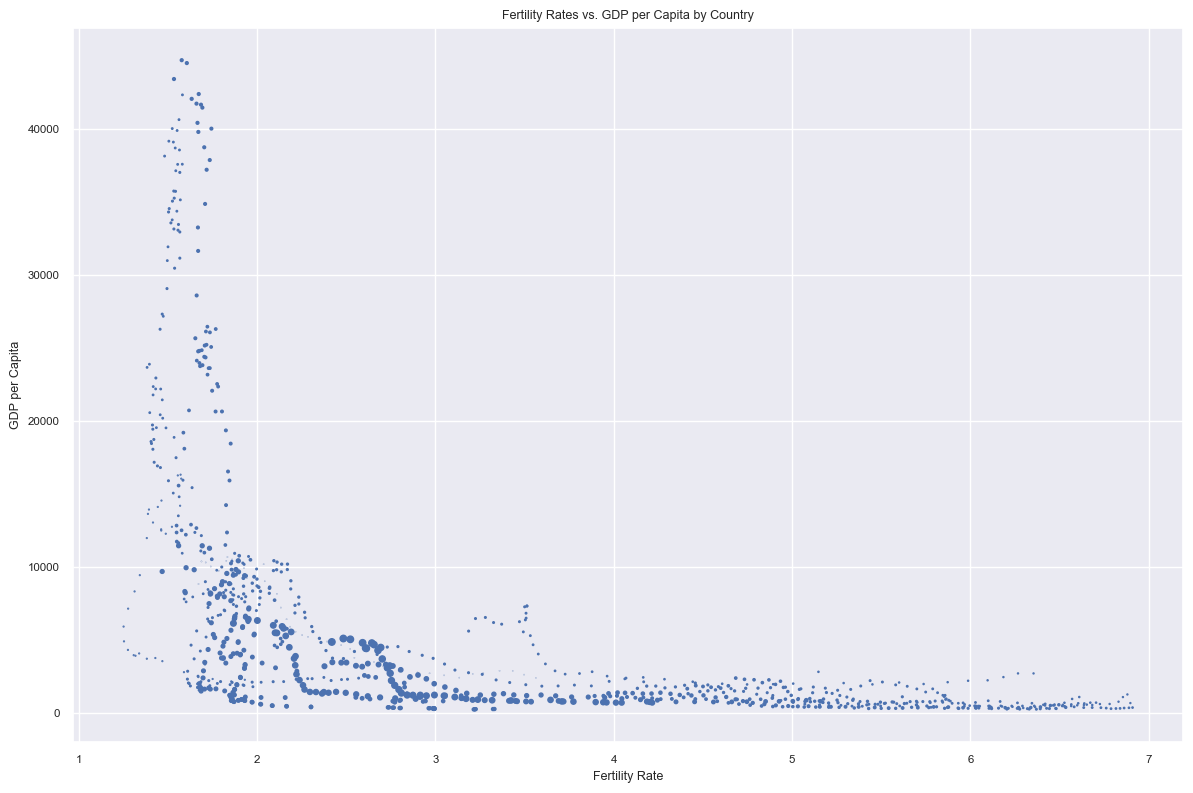

In [11]:
# Create DataFrames from fertility rate, GDP per capita, and population data
fertility_df3 = pd.DataFrame(cleaned_data_by_indicator["Fertility Rate"])
gdp_per_capita_df = pd.DataFrame(cleaned_data_by_indicator["GDP per Capita"])
population_df = pd.DataFrame(cleaned_data_by_indicator["Population"])

# Merge the three DataFrames on "Country" and "Year"
merged_df = pd.merge(fertility_df3, gdp_per_capita_df, on=["Country", "Year"])
merged_df = pd.merge(merged_df, population_df, on=["Country", "Year"])

# Set up the scatter plot figure
plt.figure(figsize=(12, 8))

# Create scatter plot
plt.scatter(
    merged_df["Value_x"],  # Fertility Rate
    merged_df["Value_y"],  # GDP per Capita
    s=merged_df["Value"] / 300000000,  # Adjust size of markers based on population
    alpha=1.0,  # Set marker transparency
    c="b",  # Set marker color
)

# Add labels and title
plt.xlabel("Fertility Rate")
plt.ylabel("GDP per Capita")
plt.title("Fertility Rates vs. GDP per Capita by Country")

# Show the plot
plt.tight_layout()
plt.show()

The graph emphasizes the correlation between fertility rate and country's wealth. We can see that there is not a clear link between the two parameters, as in the left half of the graph, it exists both rich and poor countries who have very low fertility rate. In other words, being part of the impoverished countries does not necessarily implies having a high fertility rate. However, the reciprocal is not true, as all territories with high fertility rate prooved to be undeveloped countries. A second interpretation would be to say that after a specific cap of wealth (around 1000$ per person) that is actually not that high regarding the extent of the graph, the fertility rate tends to be low. It means that emerging countries have also a low fertility rate, and the areas that have a high one tends to be very poor, which shows a clear gap in terms of repartition of fertility rate around the world

4. Create boxplots of fertility rates by income group and region.

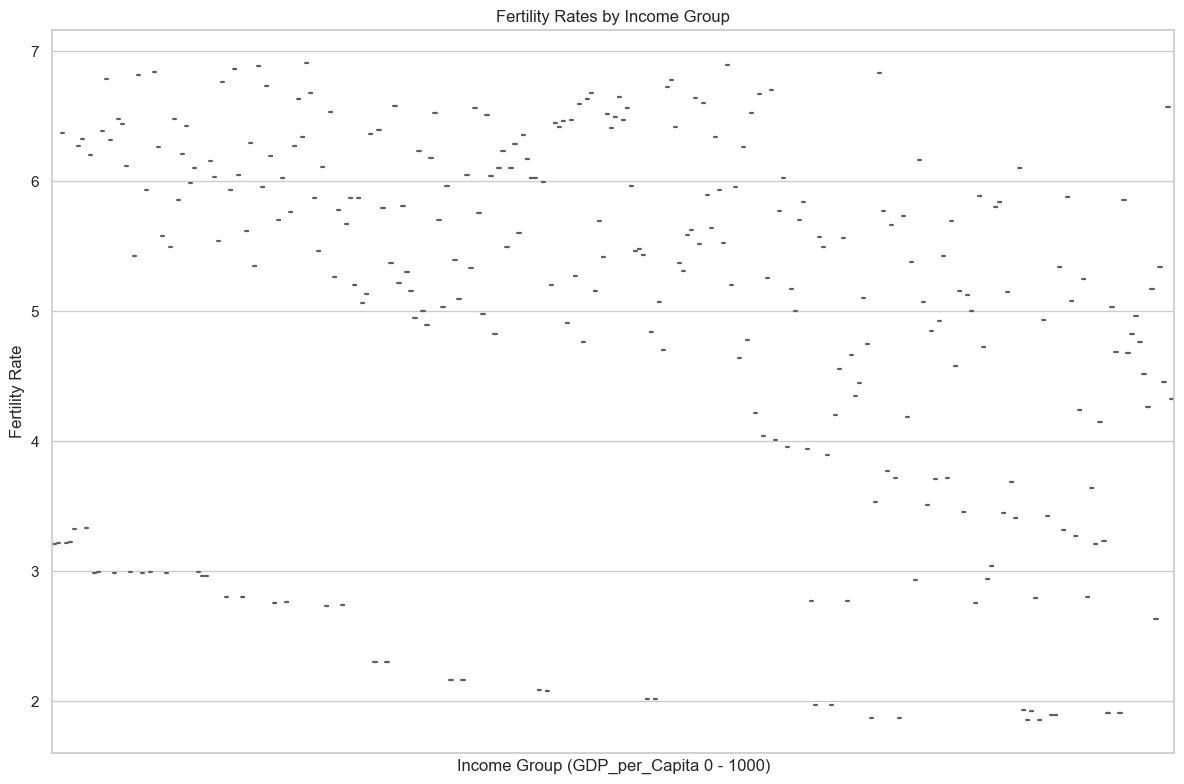

In [12]:
# Create DataFrames
fertility_df4 = pd.DataFrame(cleaned_data_by_indicator["Fertility Rate"])
gdp_per_capita_df2 = pd.DataFrame(cleaned_data_by_indicator["GDP per Capita"])

# Merge the DataFrames
merged_df2 = pd.merge(fertility_df4, gdp_per_capita_df2, on=["Country", "Year"])

income_range = gdp_per_capita_df2.loc[(gdp_per_capita_df2['Value'] >= 0) & (gdp_per_capita_df2['Value'] <= 1000), 'Value']

# Set up the boxplot figure
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create boxplot using Seaborn
sns.boxplot(
    x=income_range,
    y="Value_x",
    data=merged_df2,
    palette="Set3",
    linewidth=1.5,
)

# Add labels and title
plt.xlabel("Income Group (GDP_per_Capita 0 - 1000)")
plt.ylabel("Fertility Rate")
plt.title("Fertility Rates by Income Group")

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# Show the plot
plt.tight_layout()
plt.show()

Here, we'll take the previous analysis further by dividing the graph between 3 categories of countries, regarding there GDP par capita. This first graph refers to the poor countries. We can see that the poorest areas of the world have almost always a high fertility rate (left part of the graph), whereas the conclusion is quite shaded for the poor countries (not the poorest ones), with already a little part of them having low fertility rate

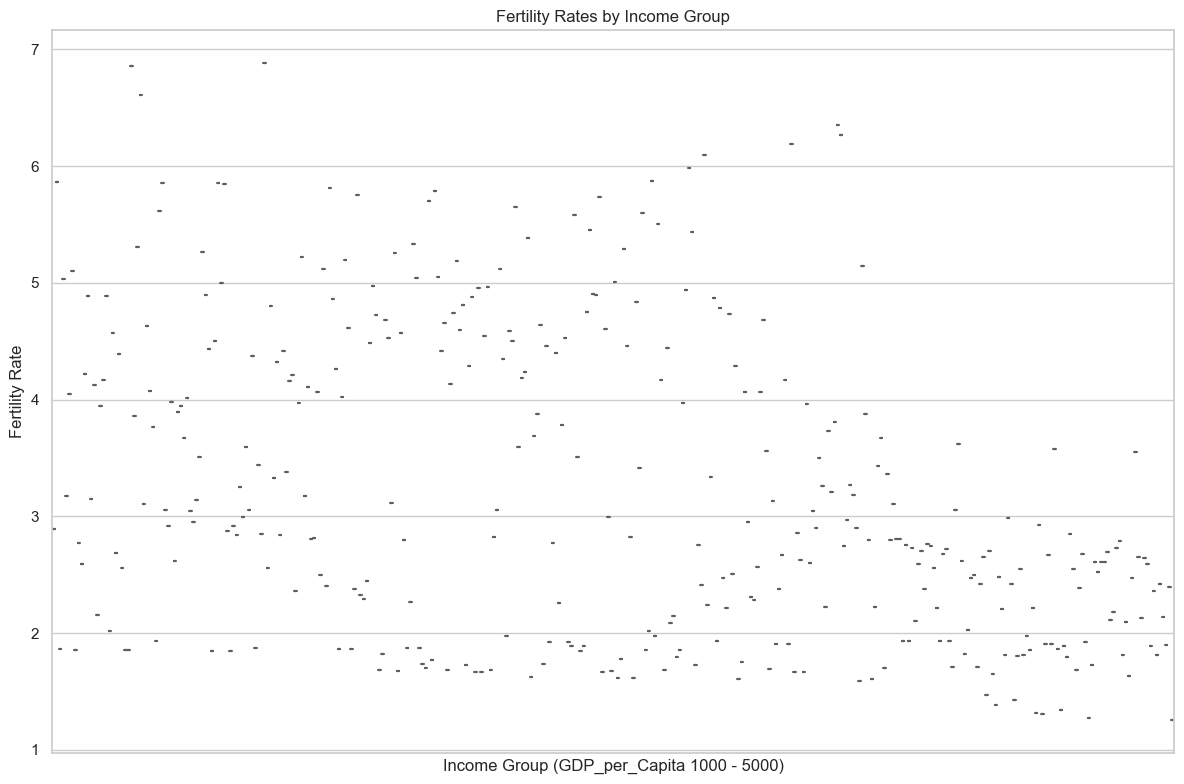

In [13]:
income_range = gdp_per_capita_df2.loc[(gdp_per_capita_df2['Value'] >= 1000) & (gdp_per_capita_df2['Value'] <= 5000), 'Value']

# Set up the boxplot figure
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create boxplot using Seaborn
sns.boxplot(
    x=income_range,
    y="Value_x",
    data=merged_df2,
    palette="Set3",
    linewidth=1.5,
)

# Add labels and title
plt.xlabel("Income Group (GDP_per_Capita 1000 - 5000)")
plt.ylabel("Fertility Rate")
plt.title("Fertility Rates by Income Group")

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# Show the plot
plt.tight_layout()
plt.show()

The second part of the sample is composed of the countries whose GDP is between 1000𝑎𝑛𝑠5000���5000 per capita, that is to say an intermediary category with emerging and pretty rich countries. Here again, we can split the graph into 2 parts, separated around a level of GDP per capita of 4000 dollars. For the countries below this level, there is no clear link between wealth and fertility rate, and can be interpretated as a continuity of the previous graph. In those cases, the fertility rate seems to depend on other and much complex criterias than only the income effect. But on the other part, areas with a GDP per capita between 4000𝑎𝑛𝑑5000���5000 have a much lower fertility rate. Again, all conclusions proove to be more relevant when applied to extrem categories (very poor or very rich countries).

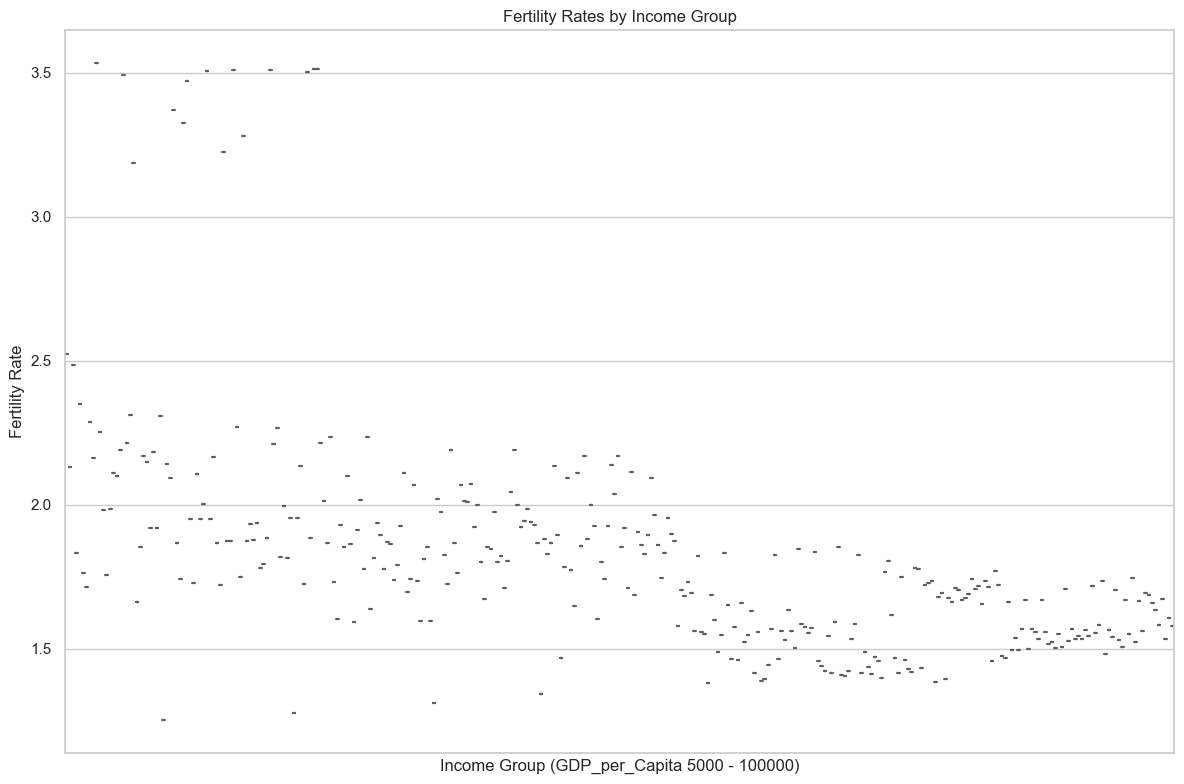

In [14]:
income_range = gdp_per_capita_df2.loc[(gdp_per_capita_df2['Value'] >= 5000) & (gdp_per_capita_df2['Value'] <= 100000), 'Value']

# Set up the boxplot figure
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create boxplot using Seaborn
sns.boxplot(
    x=income_range,
    y="Value_x",
    data=merged_df2,
    palette="Set3",
    linewidth=1.5,
)

# Add labels and title
plt.xlabel("Income Group (GDP_per_Capita 5000 - 100000)")
plt.ylabel("Fertility Rate")
plt.title("Fertility Rates by Income Group")

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# Show the plot
plt.tight_layout()
plt.show()

For the wealthiest areas of the world, the statement is much more clear : they have a low fertility rate. Again, as observed earlier, wealth automaticaly implies a low fertility rate, whereas poverty does not necessarily implies a high fertility rate. In social interpretation, we could say that in rich countries, having a certain number of children is a choice, whereas in poor countries, there are still strong barriers regarding several factors, beginning by the access to contraceptive methods, culture, etc.

5. Create a heatmap showing the correlation matrix between fertility rates and economic indicators.

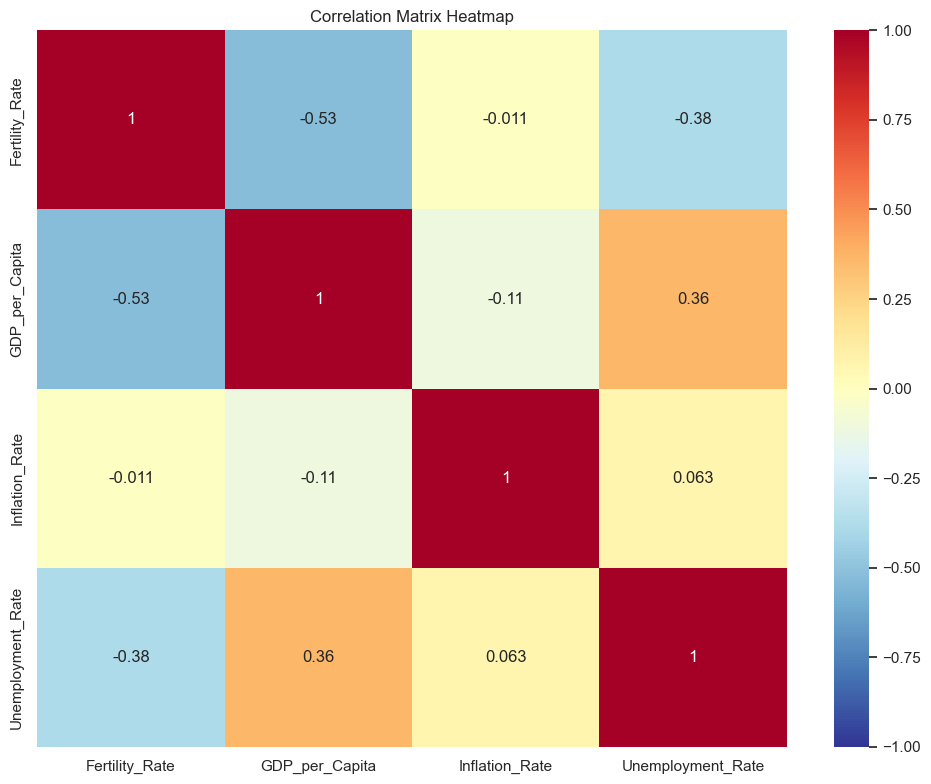

In [15]:
# Create DataFrames from the indicator data
fertility_df5 = pd.DataFrame(cleaned_data_by_indicator["Fertility Rate"])
gdp_per_capita_df3 = pd.DataFrame(cleaned_data_by_indicator["GDP per Capita"])
inflation_rate_df2 = pd.DataFrame(cleaned_data_by_indicator["Inflation Rate"])
unemployment_rate_df = pd.DataFrame(cleaned_data_by_indicator["Unemployment Rate"])

# Merge the DataFrames on "Country" and "Year"
merged_df3 = pd.merge(fertility_df5, gdp_per_capita_df3, on=["Country", "Year"])
merged_df4 = pd.merge(merged_df3, inflation_rate_df2, on=["Country", "Year"])
merged_df5 = pd.merge(merged_df4, unemployment_rate_df, on=["Country", "Year"])

merged_df5.columns = ['Country','year','Fertility_Rate', 'GDP_per_Capita', 'Inflation_Rate', 'Unemployment_Rate']

# Calculate the correlation matrix
correlation_matrix = merged_df5[["Fertility_Rate", "GDP_per_Capita", "Inflation_Rate", "Unemployment_Rate"]].corr()

# Set up the heatmap figure
plt.figure(figsize=(10, 8))

# Create heatmap using Seaborn
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="RdYlBu_r",  # Color map
    vmin=-1, vmax=1,  # Value range for the color map
)

# Add title
plt.title("Correlation Matrix Heatmap")

# Show the plot
plt.tight_layout()
plt.show()

In order to get a more precise analysis, we used some other relevant factors that could explain the fertality rate in a country. The correlation matrix helps to highlight correlation between the explained variable (fertility rate) and the explanatory variable (all the other ones), but it can also the existing links between the explanatory variables. However, we will not focus on them in this analysis. The more suitable variable implied in the fertility rate seems to be the GDP per capita, as its coefficient of correlation in absolute value is the highest. The negative coefficient means that the lowest the fertility rate is, the richest the country will be. But as explained earlier, this is not always true and it can be explained by other variables, as the unemployment rate. Here also, the coefficient of correlation (0.38) seems significant, but it needs to be verified by a regression. The more unemployed the population is, the lowest the fertility rate appears. Finally, the rate of inflation appears to have a lower impact on the fertility rate.

Regression Analysis

1. Perform a simple linear regression to investigate the relationship between fertility rates and GDP per capita.

Slope: -0.0001
Intercept: 3.8769
R-squared: 0.2811
P-value: 0.0000


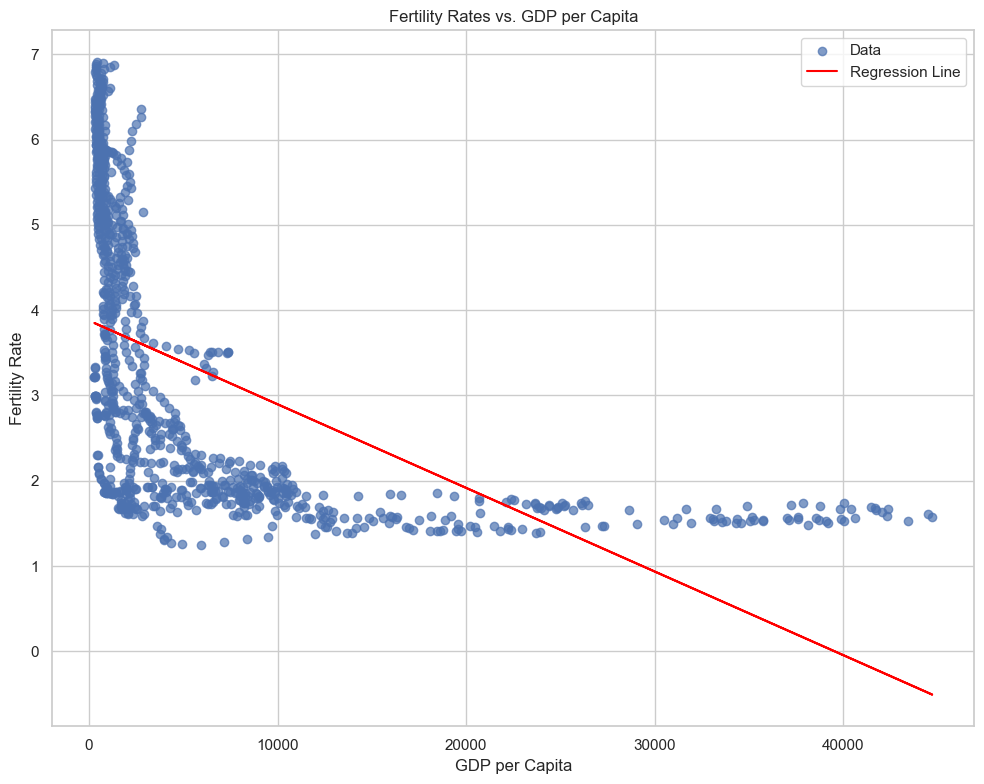

In [16]:
from scipy import stats

# Create DataFrames from the indicator data
fertility_df = pd.DataFrame(cleaned_data_by_indicator["Fertility Rate"])
gdp_per_capita_df = pd.DataFrame(cleaned_data_by_indicator["GDP per Capita"])

# Merge the DataFrames on "Country" and "Year"
merged_df = pd.merge(fertility_df, gdp_per_capita_df, on=["Country", "Year"])

# Extract variables for the linear regression
x = merged_df["Value_y"]  # GDP per Capita
y = merged_df["Value_x"]  # Fertility Rate

# Perform linear regression using scipy's linregress function
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create the regression line
regression_line = slope * x + intercept

# Print the regression results
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")

# Set up the scatter plot figure
plt.figure(figsize=(10, 8))

# Create scatter plot of the data
plt.scatter(x, y, label="Data", alpha=0.7)

# Plot the regression line
plt.plot(x, regression_line, color="red", label="Regression Line")

# Add labels and title
plt.xlabel("GDP per Capita")
plt.ylabel("Fertility Rate")
plt.title("Fertility Rates vs. GDP per Capita")

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

The goal of the regression analysis is to describe a linear/affine function between fertility rate and GDP per capita. Here, looking at the p-value that is almost null, we can deduce a significant correlation between the two variables. The R-squared of 0.2811 means that 28,11% of a potential rise or decline of the fertility rate in a country can be explain by a variation of the GDP per capita. But again, this graph does not include enough variables to be truly relevant in terms of interpretation. Indeed, the data show that an actual link exists between the two samples, but only to a certain extent (for example, only very poor countries will have a high fertility rate).

2. Perform a multiple linear regression to investigate the relationship between fertility rates and economic indicators, including GDP per capita, inflation rate, and unemployment rate

In [17]:
# Create DataFrames from the indicator data
fertility_df = pd.DataFrame(cleaned_data_by_indicator["Fertility Rate"])
gdp_per_capita_df = pd.DataFrame(cleaned_data_by_indicator["GDP per Capita"])
inflation_rate_df = pd.DataFrame(cleaned_data_by_indicator["Inflation Rate"])
unemployment_rate_df = pd.DataFrame(cleaned_data_by_indicator["Unemployment Rate"])

merged_df = pd.merge(fertility_df, gdp_per_capita_df, on=["Country", "Year"])
merged_df = pd.merge(merged_df, inflation_rate_df, on=["Country", "Year"])
merged_df = pd.merge(merged_df, unemployment_rate_df, on=["Country", "Year"])

merged_df.columns = ['Country','year','Fertility_Rate', 'GDP_per_Capita', 'Inflation_Rate', 'Unemployment_Rate']

# Define independent variables (economic indicators)
X = merged_df[["GDP_per_Capita", "Inflation_Rate", "Unemployment_Rate"]]

# Add a constant term to the independent variables matrix
X = sm.add_constant(X)

# Define the dependent variable
y = merged_df["Fertility_Rate"]

# Perform multiple linear regression using OLS (Ordinary Least Squares)
model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Fertility_Rate   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     115.9
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           2.56e-61
Time:                        23:22:13   Log-Likelihood:                -1205.8
No. Observations:                 729   AIC:                             2420.
Df Residuals:                     725   BIC:                             2438.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.4217      0.13

Here are the results of a multiple regression analysis, including the impact of inflation and unemployment rate in the explaination of the fertility rate. Looking at the P-values, we can deduce from the regression that GDP per capita and inflation rate both explains the fertility rate, even at one percent threshold. On the other hand, the unemployment rate doesn't seem to have a significant impact on the fertility rate, except if we take a 10% threshold of precision. We can also notice that some of the values of the standard errors are quite significant, which implies that the values on the factors may get away from the regression line. Some pre-requisted tests before doing the regression can also explain some non-coherent results. Indeed, the Durbin-Watson test for example detects whether there is a correlation between the different values of the residues of one variable at different time (if inflation rate(t=2) is correlated to inflation rate(t=1) for example). Here, the DB test shows a value close to 0, which implies a high autocorrelation of the residues, that can interfer in the results.

3. Perform a quantile regression to investigate the relationship between fertility rates and economic indicators across different quantiles of the distribution.

In [18]:
# Create DataFrames from the indicator data
fertility_df = pd.DataFrame(cleaned_data_by_indicator["Fertility Rate"])
gdp_per_capita_df = pd.DataFrame(cleaned_data_by_indicator["GDP per Capita"])
inflation_rate_df = pd.DataFrame(cleaned_data_by_indicator["Inflation Rate"])
unemployment_rate_df = pd.DataFrame(cleaned_data_by_indicator["Unemployment Rate"])

# Merge the DataFrames on "Country" and "Year"
merged_df = pd.merge(fertility_df, gdp_per_capita_df, on=["Country", "Year"])
merged_df = pd.merge(merged_df, inflation_rate_df, on=["Country", "Year"])
merged_df = pd.merge(merged_df, unemployment_rate_df, on=["Country", "Year"])

merged_df.columns = ['Country','year','Fertility_Rate', 'GDP_per_Capita', 'Inflation_Rate', 'Unemployment_Rate']

# Define independent variables (economic indicators)
X = merged_df[["GDP_per_Capita", "Inflation_Rate", "Unemployment_Rate"]]

# Add a constant term to the independent variables matrix
X = sm.add_constant(X)

# Define the dependent variable
y = merged_df["Fertility_Rate"]

# Quantile levels for regression
quantiles = [0.25, 0.5, 0.75]

# Perform quantile regression for each quantile
quantile_results = []
for q in quantiles:
    model = sm.QuantReg(y, X).fit(q=q)
    quantile_results.append(model)

# Print quantile regression summaries
for i, model in enumerate(quantile_results):
    print(f"Quantile {quantiles[i]}:")
    print(model.summary())
    print("=" * 50)

Quantile 0.25:
                         QuantReg Regression Results                          
Dep. Variable:         Fertility_Rate   Pseudo R-squared:              0.08132
Model:                       QuantReg   Bandwidth:                      0.7375
Method:                 Least Squares   Sparsity:                        1.930
Date:                Thu, 14 Sep 2023   No. Observations:                  729
Time:                        23:22:18   Df Residuals:                      725
                                        Df Model:                            3
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.1865      0.101     21.597      0.000       1.988       2.385
GDP_per_Capita    -1.292e-05   2.59e-06     -4.989      0.000    -1.8e-05   -7.84e-06
Inflation_Rate        0.0003      0.002      0.130      0.896      -0.004       0.004
Un

4. Perform a panel data regression to account for time-invariant country-specific effects and investigate the relationship between fertility rates and economic indicators over time.

In [19]:
# Combine cleaned data into a single DataFrame
data = []
for indicator_name, cleaned_data in cleaned_data_by_indicator.items():
    df = pd.DataFrame(cleaned_data)
    df['Indicator'] = indicator_name
    data.append(df)
    
panel_data = pd.concat(data)

# Create a pivot table to prepare the data for regression
pivot_data = panel_data.pivot_table(index=['Country', 'Year'], columns='Indicator', values='Value').reset_index()

# Drop rows with missing or infinite values
pivot_data_cleaned = pivot_data.dropna(subset=['GDP per Capita', 'Unemployment Rate', 'Inflation Rate', 'Fertility Rate'])
pivot_data_cleaned = pivot_data_cleaned.replace([np.inf, -np.inf], np.nan).dropna()

# Prepare the cleaned data for regression
X_cleaned = pivot_data_cleaned[['GDP per Capita', 'Unemployment Rate', 'Inflation Rate']]
X_cleaned = sm.add_constant(X_cleaned)
y_cleaned = pivot_data_cleaned['Fertility Rate']

# Perform fixed-effects panel data regression on cleaned data
model_cleaned = sm.OLS(y_cleaned, X_cleaned).fit()
print(model_cleaned.summary())


                            OLS Regression Results                            
Dep. Variable:         Fertility Rate   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     115.9
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           2.56e-61
Time:                        23:22:22   Log-Likelihood:                -1205.8
No. Observations:                 729   AIC:                             2420.
Df Residuals:                     725   BIC:                             2438.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.4217      0.13

Time Series Analysis

1. Conduct a time series decomposition to identify trends, seasonal patterns, and irregular fluctuations in fertility rates and economic indicators.

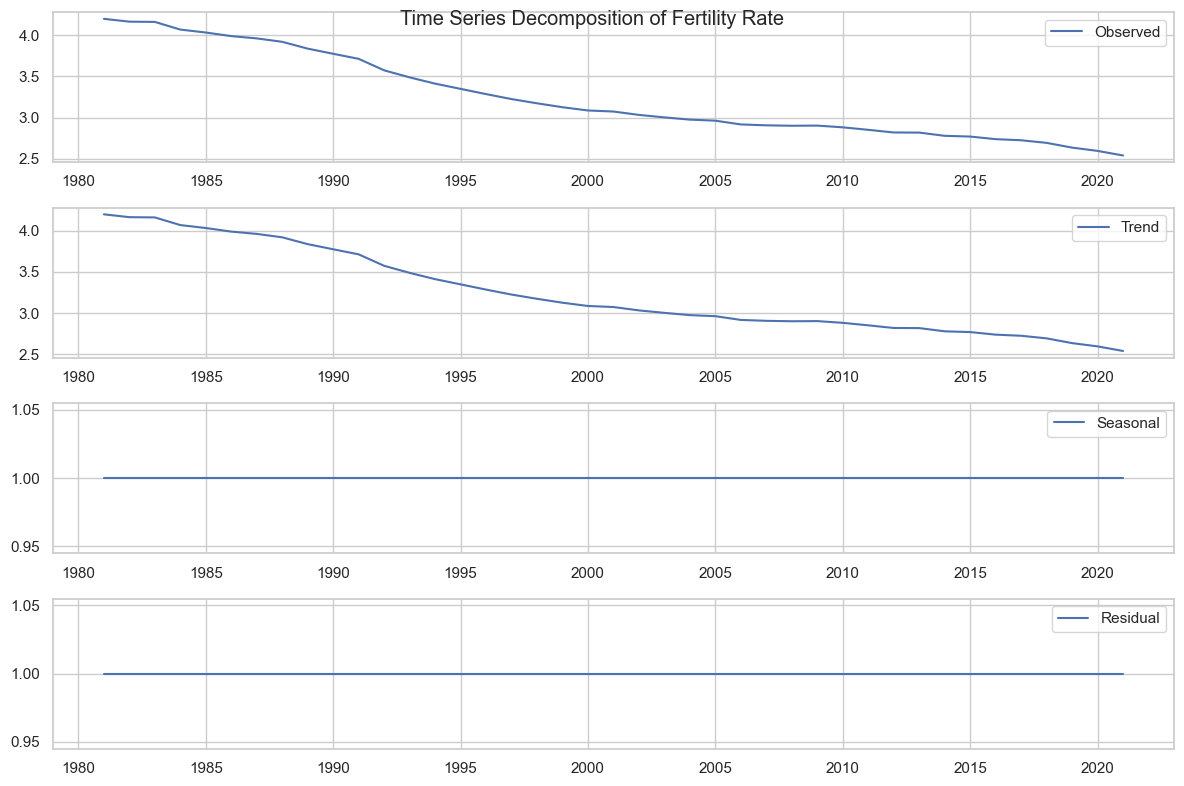

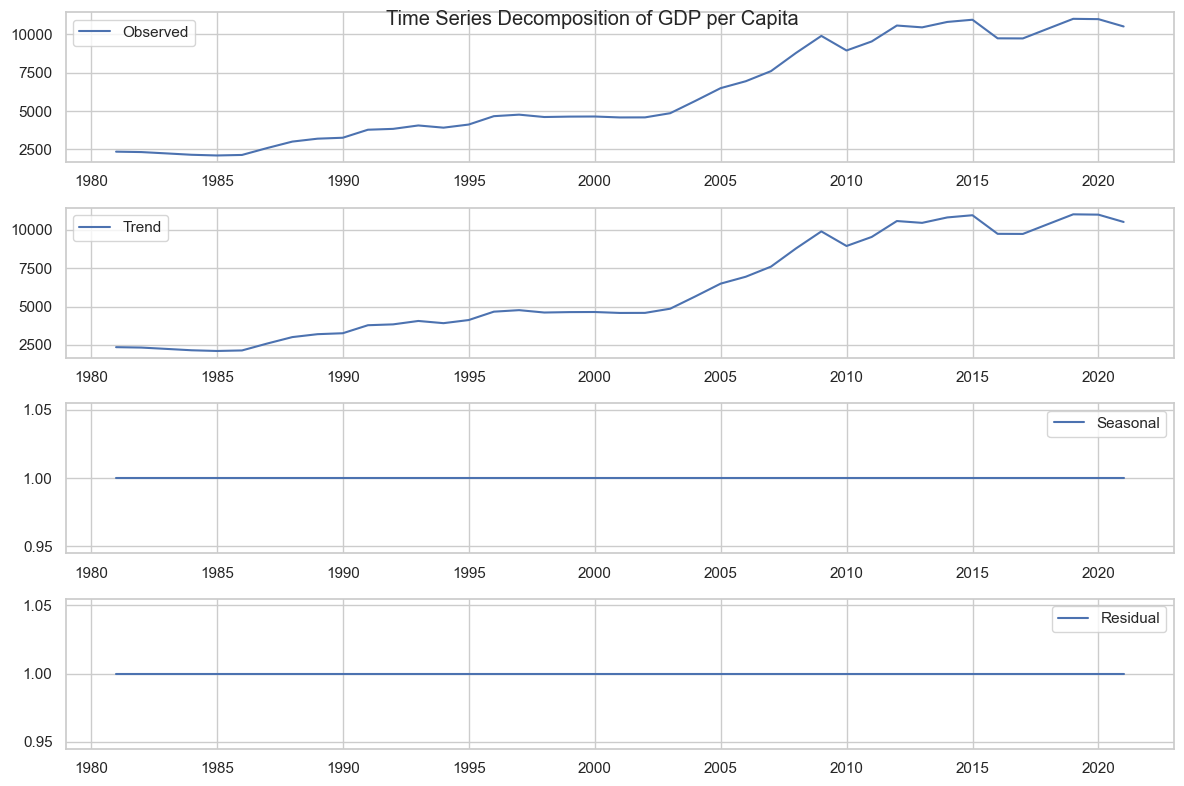

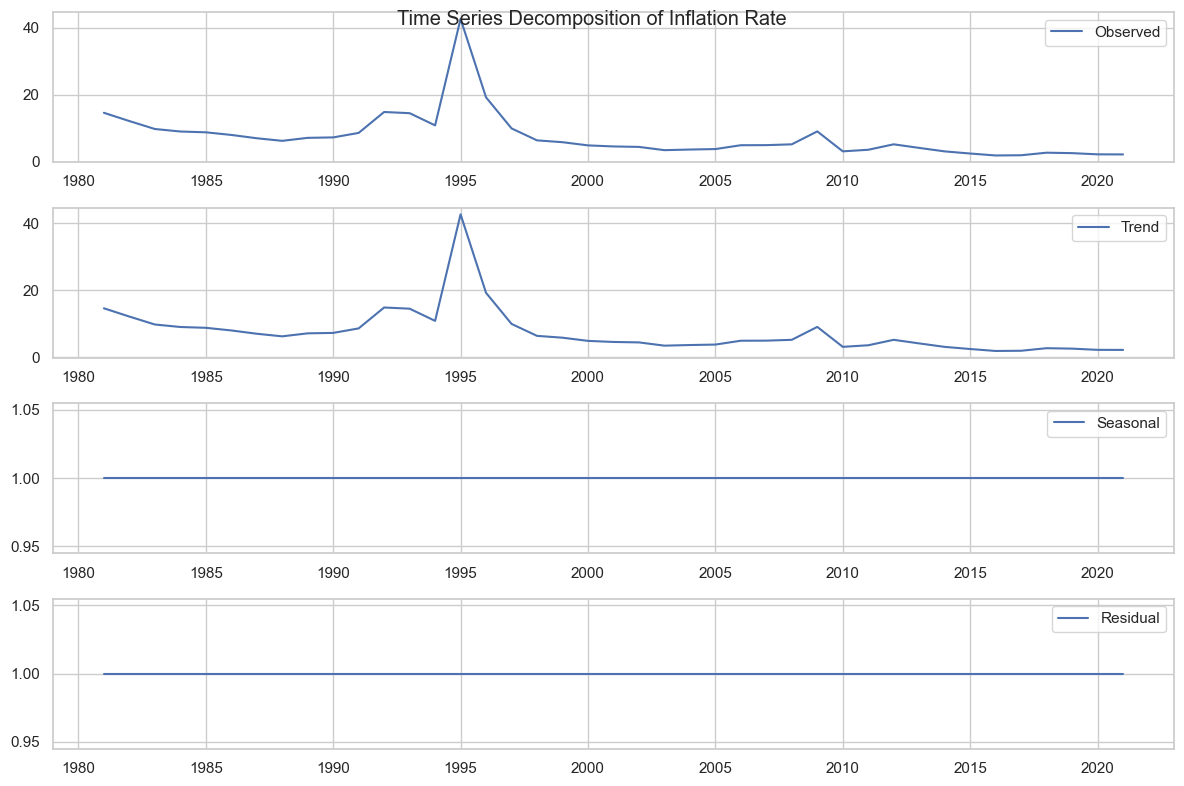

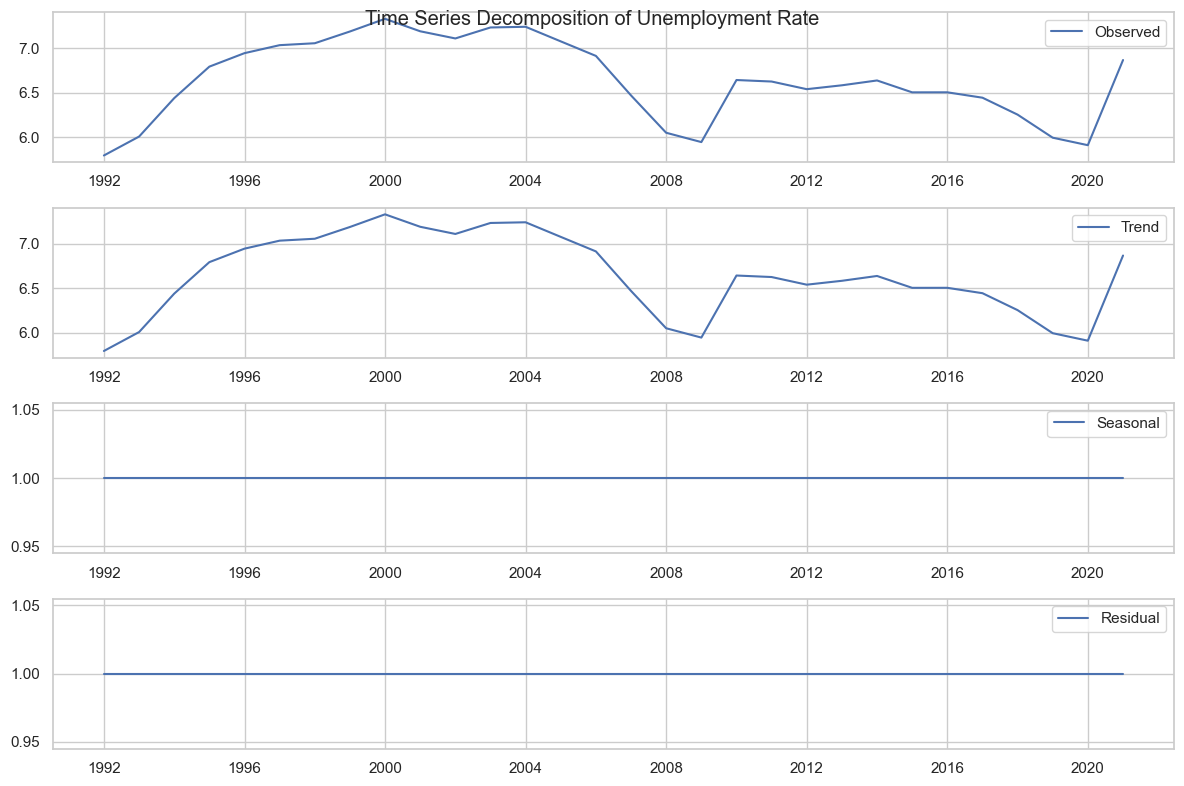

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Conduct time series decomposition
def conduct_decomposition(data, indicator_name):
    df = pd.DataFrame(data)
    df['Year'] = pd.to_datetime(df['Year'])
    df.set_index('Year', inplace=True)
    
    # Ensure a consistent frequency for the datetime index
    df = df.resample('A').mean()  # Resample annually
    
    result = seasonal_decompose(df['Value'], model='multiplicative', extrapolate_trend='freq')
    
    # Plot the decomposition components
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(result.observed, label='Observed')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(result.trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(result.seasonal, label='Seasonal')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(result.resid, label='Residual')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.suptitle(f"Time Series Decomposition of {indicator_name}")
    plt.show()

# Conduct decomposition for Fertility Rate
fertility_data = cleaned_data_by_indicator["Fertility Rate"]
conduct_decomposition(fertility_data, "Fertility Rate")

# Conduct decomposition for GDP per Capita
gdp_data = cleaned_data_by_indicator["GDP per Capita"]
conduct_decomposition(gdp_data, "GDP per Capita")

# Conduct decomposition for Inflation Rate
gdp_data = cleaned_data_by_indicator["Inflation Rate"]
conduct_decomposition(gdp_data, "Inflation Rate")

# Conduct decomposition for Unemployment Rate
gdp_data = cleaned_data_by_indicator["Unemployment Rate"]
conduct_decomposition(gdp_data, "Unemployment Rate")

2. Perform a time series regression to investigate the relationship between fertility rates and economic indicators, accounting for time series effects such as autocorrelation and heteroskedasticity.

In [21]:
# Load the cleaned data for Fertility Rate and GDP per Capita
fertility_data = cleaned_data_by_indicator["Fertility Rate"]
gdp_data = cleaned_data_by_indicator["GDP per Capita"]

# Create dataframes for the fertility rate and GDP per Capita
fertility_df = pd.DataFrame(fertility_data)
gdp_df = pd.DataFrame(gdp_data)

# Merge the two dataframes based on the "Country" and "Year" columns
merged_df = pd.merge(fertility_df, gdp_df, on=["Country", "Year"], how="inner")

# Define the dependent variable (y) and the independent variable (X)
y = merged_df["Value_x"]  # Fertility Rate
X = merged_df["Value_y"]  # GDP per Capita

# Add a constant to the independent variable matrix
X = sm.add_constant(X)

# Fit a linear regression model
model = sm.OLS(y, X).fit()

# Display the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Value_x   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     380.1
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           1.06e-71
Time:                        23:22:36   Log-Likelihood:                -1728.6
No. Observations:                 974   AIC:                             3461.
Df Residuals:                     972   BIC:                             3471.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8769      0.056     69.659      0.0

3. Use forecasting models such as ARIMA and VAR to predict future fertility rates and economic indicators

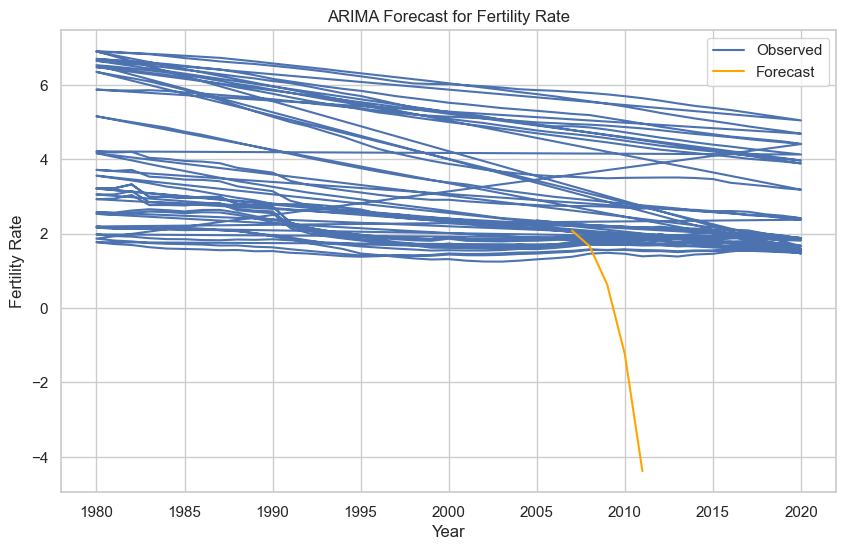

In [31]:
from statsmodels.tsa.arima.model import ARIMA

# Ignore warning
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels.tsa.base.tsa_model")

# Load the cleaned data for Fertility Rate
fertility_data = cleaned_data_by_indicator["Fertility Rate"]

# Create a dataframe for fertility rates
fertility_df = pd.DataFrame(fertility_data)
fertility_df['Year'] = pd.to_datetime(fertility_df['Year'])
fertility_df.set_index('Year', inplace=True)

# Convert the "Value" column to numeric type, handling non-numeric values
fertility_df["Value"] = pd.to_numeric(fertility_df["Value"], errors='coerce')

# Drop rows with missing or non-numeric values
fertility_df.dropna(subset=["Value"], inplace=True)

# Select only the "Value" column for ARIMA analysis
fertility_values = fertility_df["Value"]

# Fit an ARIMA model with p=2, d=1, q=2
p, d, q = 10, 10, 8
model = ARIMA(fertility_values, order=(p, d, q))
results = model.fit()

# Forecast future fertility rates
forecast_steps = 5  # Number of steps to forecast
forecast = results.forecast(steps=forecast_steps)

# Plot the observed and forecasted fertility rates
plt.figure(figsize=(10, 6))
plt.plot(fertility_values.index, fertility_values, label='Observed')
plt.plot(pd.date_range(start=fertility_values.index[-1], periods=forecast_steps+1, freq='Y')[1:], forecast, label='Forecast', color='orange')
plt.legend()
plt.title('ARIMA Forecast for Fertility Rate')
plt.xlabel('Year')
plt.ylabel('Fertility Rate')
plt.show()

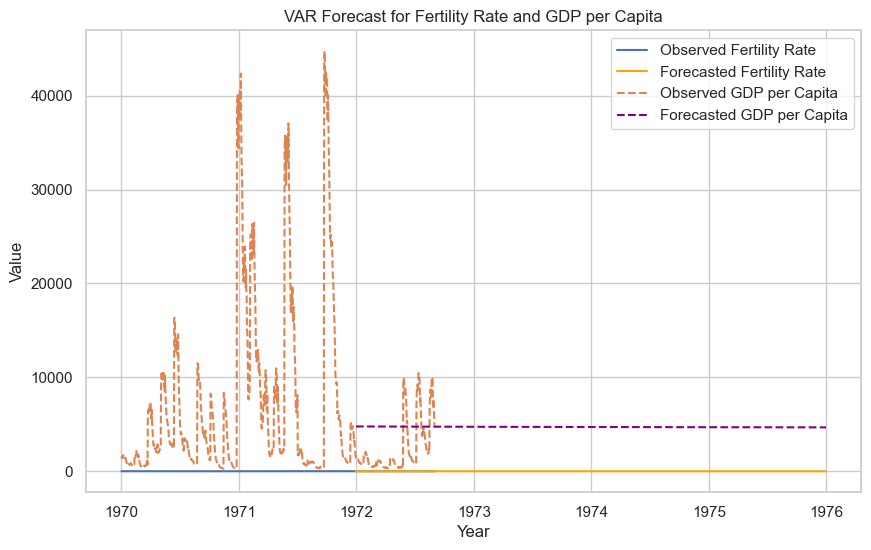

In [26]:
from statsmodels.tsa.api import VAR

# Load the cleaned data for Fertility Rate and GDP per Capita
fertility_data = cleaned_data_by_indicator["Fertility Rate"]
gdp_data = cleaned_data_by_indicator["GDP per Capita"]

# Create dataframes for fertility rates and GDP per Capita
fertility_df = pd.DataFrame(fertility_data)
gdp_df = pd.DataFrame(gdp_data)

# Merge the two dataframes based on the "Country" and "Year" columns
merged_df = pd.merge(fertility_df, gdp_df, on=["Country", "Year"], how="inner")

# Create a dataframe with the required variables
var_data = merged_df[["Value_x", "Value_y"]]

# Fit a VAR model
model = VAR(var_data)
results = model.fit(maxlags=2, ic='aic')

# Forecast future values
forecast_steps = 5  # Number of steps to forecast
forecast = results.forecast(var_data.values[-results.k_ar:], steps=forecast_steps)

# Plot the observed and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(merged_df.index, merged_df["Value_x"], label='Observed Fertility Rate')
plt.plot(pd.date_range(start=merged_df.index[-1], periods=forecast_steps+1, freq='Y')[1:], forecast[:, 0], label='Forecasted Fertility Rate', color='orange')
plt.plot(merged_df.index, merged_df["Value_y"], label='Observed GDP per Capita', linestyle='dashed')
plt.plot(pd.date_range(start=merged_df.index[-1], periods=forecast_steps+1, freq='Y')[1:], forecast[:, 1], label='Forecasted GDP per Capita', color='purple', linestyle='dashed')
plt.legend()
plt.title('VAR Forecast for Fertility Rate and GDP per Capita')
plt.xlabel('Year')
plt.ylabel('Value')
plt.show()

Conclusion

The relationship between fertility rates and economic development is shaped by various factors. Developing countries tend to have higher fertility rates due to limited access to education, healthcare, and family planning. Economic growth initially can lead to increased fertility, but as development progresses and women's education and workforce participation rise, fertility rates often decline. Urbanization, women's empowerment, government policies, and cultural norms all play roles. However, individual countries may deviate from these trends due to unique circumstances, making the relationship complex and multifaceted.

The two sets of regression results reflect different analytical approaches. The first set examines cross-sectional data, studying the relationship between fertility rates and economic factors like GDP per Capita, Inflation Rate, and Unemployment Rate. This model demonstrates moderate explanatory power (R-squared: 0.324) and a statistically significant overall fit (F-statistic: 115.9). In contrast, the second set employs time series analysis, investigating how one variable evolves over time. It reveals a relationship between two variables (Value_x and Value_y) with a somewhat lower explanatory ability (R-squared: 0.281) but a stronger overall significance (F-statistic: 380.1).